In [1]:
# stave.py
# Computes Student's t average, with the number of degrees of
# freedom nu related to the relative uncertainty r in the
# standard deviations of the measurements, nu = 1/(2*r**2), see
# G. Cowan, Eur. Phys. J. C (2019) 79 :133, arXiv:1809.05778.
# Uses iminuit version 2.x (not compatible with v 1.x).
# G. Cowan / RHUL Physics / December 2022

import numpy as np
import scipy.stats as stats
from scipy.stats import truncexpon
from scipy.stats import truncnorm
import iminuit
from iminuit import Minuit
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14
print(f"iminuit version: {iminuit.__version__}")      #  should be v 2.x

iminuit version: 2.16.0


In [2]:
# Set input values
mu = 10.                                  # initial value for fit
y = np.array([17., 19., 15., 3.])         # measured values
s = np.array([1.5, 1.5, 1.5, 1.5])        # estimates of std. dev
v = s**2                                  # estimates of variances
r = np.array([0.2, 0.2, 0.2, 0.2])        # relative errors on errors
x = np.array([1., 2., 3., 4.])            # arbitrary x coord. for measurements

In [3]:
# Define function to be minimized
class NegLogL:

    def __init__(self, y, s, r):
        self.setData(y, s, r)
        
    def setData(self, y, s, r):
        self.data = y, s, r

    def __call__(self, mu):
        y, s, r = self.data
        v = s ** 2
        lnf = -0.5*(1. + 1./(2.*r**2))*np.log(1. + 2.*(r*(y-mu))**2/v)
        return -np.sum(lnf)

In [4]:
# Initialize Minuit and set up fit:
negLogL = NegLogL(y, s, r)          # instantiate function to be minimized
parin     = np.array([mu])          # initial values
parname = ['mu']
parstep = np.array([0.5])           # initial setp sizes
parfix  = [False]                   # change these to fix/free parameters
parlim  = [(None, None)]
m = Minuit(negLogL, parin, name=parname)
m.errors = parstep
m.fixed = parfix
m.limits = parlim
m.errordef = 0.5                           # errors from lnL = lnLmax - 0.5

In [5]:
# do the fit, extract results
m.migrad()                                        # minimize -logL
MLE = m.values                                    # max-likelihood estimates
sigmaMLE = m.errors                               # standard deviations
cov = m.covariance                                # covariance matrix
rho = m.covariance.correlation()                  # correlation coeffs.
muHat = MLE[0]
sigma_muHat = sigmaMLE[0]

print(r"par index, name, estimate, standard deviation:")
for i in range(m.npar):
    if not m.fixed[i]:
        print("{:4d}".format(i), "{:<10s}".format(m.parameters[i]), " = ",
         "{:.6f}".format(MLE[i]), " +/- ", "{:.6f}".format(sigmaMLE[i]))

par index, name, estimate, standard deviation:
   0 mu          =  16.205276  +/-  0.987898


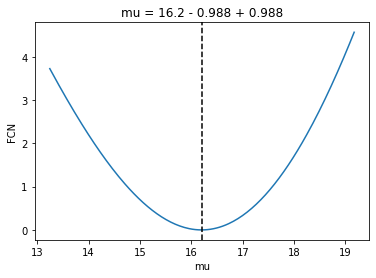

In [6]:
# Make scan of -lnL
if not m.fixed["mu"]:
    plt.figure()
    m.draw_mnprofile('mu', band=False, bound=(muHat-3.*sigma_muHat, muHat+3.*sigma_muHat), size=200)
    plt.show()

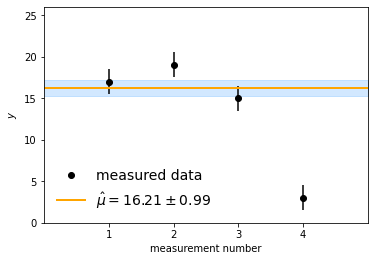

In [7]:
# Plot fit
fig, ax = plt.subplots(1,1)
plt.errorbar(x, y, yerr=s, xerr=0, color='black', fmt='o', label='measured data')
plt.xlabel(r'measurement number')
plt.ylabel(r'$y$', labelpad=5)
xMin = 1.e-4
xMax = 5. - 1.e-4
yMin = 0.
yMax = 26.
plt.xlim(xMin, xMax)
plt.ylim(yMin, yMax)
xPlot = np.array([xMin, xMax])
fit = np.array([muHat, muHat])
plotLabel = r'$\hat{\mu} = ' + '{:.2f}'.format(muHat) + '\pm' + '{:.2f}'.format(sigma_muHat) + '$'
plt.plot(xPlot, fit, 'orange', linewidth=2, label=plotLabel)
fitUp = np.array([muHat+sigma_muHat, muHat+sigma_muHat])
fitLo = np.array([muHat-sigma_muHat, muHat-sigma_muHat])
plt.fill_between(xPlot, fitLo, fitUp, color='dodgerblue', alpha=0.2)
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)
handles, labels = ax.get_legend_handles_labels()  # Tweak legend
handles = [handles[1], handles[0]]
labels = [labels[1], labels[0]]
handles = [handles[0][0], handles[1]]    # turn off error bar for data in legend
plt.legend(handles, labels, loc='lower left', fontsize=14, frameon=False)
plt.show()